# Abstract classification

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import utils # all datareading and preprocessing functionality

## Current analysis configuration

In [2]:
file1 = './data/abstract_set1.txt' # pesticides
file2 = './data/abstract_set2.txt' # cancer-ish
file3 = './data/validation_set_master.csv' # more or less random set of papers
data_selection = 'abstract_clean'
label_selection = 'text_label'

In [3]:
# the custom class Tokenizer can also lemmatize, and remove short words, digits and stopwords
stopwords = utils.get_stopwords(custom = {'wa', 'use', 'using', 'one', 'two', 'three', 'study'}) 
#custom = {'pesticide', 'pesticides'})

tokenizer = utils.Tokenizer(stop_words=stopwords, min_length=3)
#tokenizer = utils.StemTokenizer()

**Note** I have tried with and without the words "pesticide" and "pesticides" present in `stopwords`, but this had only minor effect on the performance of the different models.

**Note** The word 'wa' appeared in all categories with lda; this is probably a lemmatization thing. Put it nito the stopwords set.

## Load, preprocess and inspect

In [91]:
data = utils.read_abstract_data(file1, file2)

# no need to catch return value; dataframe operations are in-place
# no need to remove punctuation in this step when using nltk.tokenize_word() 
# which is implemented in utils.tokenize_text()
utils.preprocess_text(data)

data.head()

,pmid,title,abstract,label,text_label,title_clean,abstract_clean
0,29990300,Oxidative stress in triazine pesticide toxicit...,This review article provides a summary of the ...,1,pest,oxidative stress in triazine pesticide toxicit...,this review article provides a summary of the ...
1,29990732,Toxicity induced by glyphosate and glyphosate-...,Glyphosate is the active component of many com...,1,pest,toxicity induced by glyphosate and glyphosate-...,glyphosate is the active component of many com...
2,29999060,Direct kinetics study of CH2OO + methyl vinyl ...,Methyl vinyl ketone (MVK) and methacrolein (MA...,1,pest,direct kinetics study of ch2oo + methyl vinyl ...,methyl vinyl ketone (mvk) and methacrolein (ma...
3,30003825,Dihydromyricetin improves vascular hyporespons...,CONTEXT: Dihydromyricetin (DMY) has oxidation ...,1,pest,dihydromyricetin improves vascular hyporespons...,context: dihydromyricetin (dmy) has oxidation ...
4,30015122,Glyphosate and atrazine in rainfall and soils ...,The presence in the atmosphere of glyphosate (...,1,pest,glyphosate and atrazine in rainfall and soils ...,the presence in the atmosphere of glyphosate (...


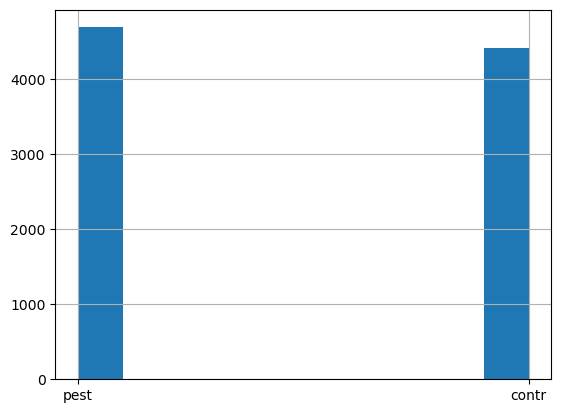

In [9]:
data[label_selection].hist();

## Wordclouds without any processing

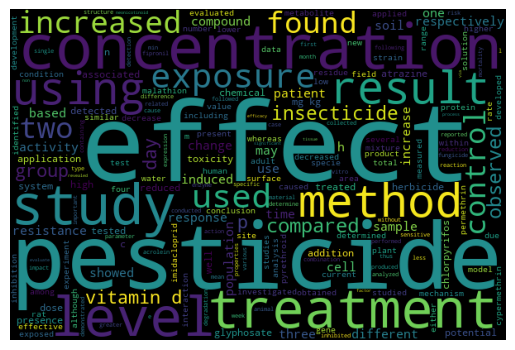

In [10]:
utils.visualize(data, 'pest')

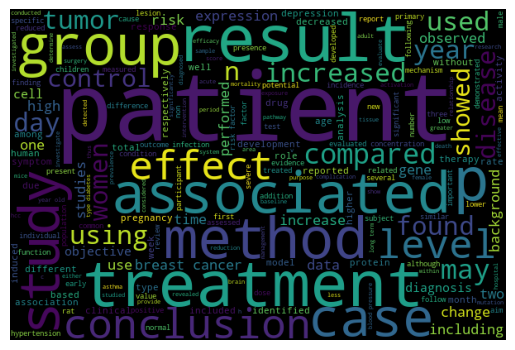

In [11]:
utils.visualize(data, 'contr')

Required data for generating a wordclouod.  
The `wordcloud` lib simply takes an input string:

```python
label = 'contr'
words = ''
for abstr in data[data['text_label'] == label]['abstract_clean']:
    abstr += msg + ' '
words[:200]
```

Outputs

```
'background: breast cancer subtype, as determined by the expression of estrogen receptor (er) and progesterone receptor (pr), together defined as hormone receptor (hr) status, and the her2/neu receptor'
```

### Strategy

- Create dicts of word frequencies for both sets, after regular tokenization.
- Normalize counts
- Remove low-counting words (e.g. counts below 10) from both sets
- Subtract one set from the other, omitting words that get negative values
- Visualize the N most occurring words 

### Create dicts of words

In [12]:
def get_word_counts(df, label, tokenizer):
    counts = {}
    for abstr in df[df['text_label'] == label]['abstract_clean']:
        words = tokenizer.tokenize_text(abstr)
        for word in words:
            counts[word] = counts.get(word, 0) + 1
    return counts

In [13]:
pest_counts = get_word_counts(data, "pest", tokenizer)
print(len(pest_counts))

39896


In [14]:
contr_counts = get_word_counts(data, "contr", tokenizer)
print(len(contr_counts))

35065


In [15]:
# inspect a few
for i, item in enumerate(sorted(contr_counts.items(), key=lambda x: x[1], reverse=True)):
    print(f'word:{item}')
    if i == 10: 
        break

word:('patient', 8256)
word:('cell', 3450)
word:('result', 2864)
word:('group', 2761)
word:('disease', 2759)
word:('treatment', 2540)
word:('level', 1975)
word:('cancer', 1942)
word:('effect', 1894)
word:('risk', 1870)
word:('case', 1817)


### Normalize counts


In [16]:
def normalize_counts(count_dict):
    # first pass to get totals
    word_count = 0
    for (word, count) in count_dict.items():
        word_count += count
    print(f'total word count: {word_count}')

    # second pass to normalize
    for (word, count) in count_dict.items():
        count_dict[word] = count_dict[word] / word_count
    return count_dict


In [17]:
pest_normalized = normalize_counts(pest_counts.copy())
contr_normalized = normalize_counts(contr_counts.copy())

total word count: 551926
total word count: 538511


In [18]:
# inspect a few
for i, item in enumerate(sorted(pest_normalized.items(), key=lambda x: x[1], reverse=True)):
    print(f'word:{item}')
    if i == 10: 
        break

word:('effect', 0.006297945739102706)
word:('pesticide', 0.005718157868989684)
word:('concentration', 0.005366661472733664)
word:('result', 0.004752448697832681)
word:('level', 0.004573076825516464)
word:('activity', 0.003957052213521378)
word:('insecticide', 0.0037758685041110584)
word:('cell', 0.0037197015541938594)
word:('control', 0.0035693190753832943)
word:('exposure', 0.0035512007044422624)
word:('resistance', 0.003379076180502459)


### Filter low-count words

In [19]:
def filter_word_counts(word_counts, top_n = 1000):
    '''filters low-occurring words; only keeps the top-n words'''
    filtered = dict()
    
    for i, item in enumerate(sorted(word_counts.items(), 
                                    key=lambda x: x[1], 
                                    reverse=True), 
                             start=1):
        filtered[item[0]] = item[1]
        if i == top_n:
            # may never be reached with small sets
            break
            
    return filtered

In [20]:
filtered_pest_counts = filter_word_counts(pest_normalized)
print(len(filtered_pest_counts))

1000


In [21]:
filtered_contr_counts = filter_word_counts(contr_normalized)
print(len(filtered_contr_counts))

1000


### Subtract control from pesticide counts


In [22]:
# starting counts pest:
print(len(pest_counts))
print(len(filtered_pest_counts))

39896
1000


In [23]:
# starting counts contr:
print(len(contr_counts))
print(len(filtered_contr_counts))

35065
1000


First a small experiment: **how many words are unique resp. in common for both word sets.**

In [24]:
pest_words = set(pest_counts.keys())
contr_words = set(contr_counts.keys())

In [25]:
pest_words_filtered = set(filtered_pest_counts.keys())
contr_words_filtered = set(filtered_contr_counts.keys())

In [26]:
# Union of original
print(f'Union of original word sets: {len(pest_words.union(contr_words))}')
# Union of filtered
print(f'Union of filtered word sets: {len(pest_words_filtered.union(contr_words_filtered))}')

Union of original word sets: 60488
Union of filtered word sets: 1369


In [27]:
# Intersection of original
print(f'Intersection of original word sets: {len(contr_words.intersection(pest_words))}')
# Intersection of filtered
print(f'Intersection of filtered word sets: {len(pest_words_filtered.intersection(contr_words_filtered))}')

Intersection of original word sets: 14473
Intersection of filtered word sets: 631


To me this is a bit surprising: the apparent low amount of overlap between the two word sets (filtered and non-filtered)

### Subtract control from pesticide wordsets

#### ! The counts will probably have to be normalized !

In [29]:
def subtract_word_counts(set1, set2, top_n=1000):
    '''set2 will be subtracted from set1. Only the top_n words in set1 will be returned'''
    set1 = set1.copy()
    for (word, count) in set2.items():
        if word in set1:
            set1[word] = set1[word] - set2[word]
    return filter_word_counts(set1, top_n)

In [70]:
subtracted_pest = subtract_word_counts(filtered_pest_counts, filtered_contr_counts, top_n=100)
# print a few
subtract_word_counts(filtered_pest_counts, filtered_contr_counts, top_n=10)

{'pesticide': 0.005718157868989684,
 'concentration': 0.004202339852562488,
 'insecticide': 0.0037758685041110584,
 'exposure': 0.002851122154514777,
 'effect': 0.002780840238936507,
 'resistance': 0.002413450594395583,
 'water': 0.0022924445647669787,
 'vitamin': 0.002218036697586614,
 'soil': 0.002110790214630222,
 'activity': 0.002036942874993474}

In [71]:
subtracted_contr = subtract_word_counts(filtered_contr_counts, filtered_pest_counts, top_n=100)
# print a few
subtract_word_counts(filtered_contr_counts, filtered_pest_counts, top_n=10)

{'patient': 0.013640719142929353,
 'disease': 0.004150430003675952,
 'cancer': 0.0032166951944208005,
 'tumor': 0.0027434960683188183,
 'cell': 0.002686852815169069,
 'case': 0.002683808701677825,
 'clinical': 0.0024957257382953965,
 'woman': 0.0022938766707693275,
 'associated': 0.002108102287240965,
 'breast': 0.002090950788377582}

### Inflate and concatenate normalized counts for wordcloud purposes

In [28]:
pest_small_test_set = filter_word_counts(pest_normalized, top_n=8)
contr_small_test_set = filter_word_counts(contr_normalized, top_n=8)

In [69]:
import math
def make_string(normalized_word_dict, expand_factor=1000):
    for (word, count) in normalized_word_dict.items():
        ## expand back to integer counts
        normalized_word_dict[word] = math.ceil(normalized_word_dict[word] * expand_factor)
    # print(normalized_word_dict)
    ## make the string
    word_list = [' '.join([word] * count) for (word, count) in normalized_word_dict.items()]
    return ' '.join(word_list)

In [78]:
wc_string = make_string(subtracted_pest.copy())
#wc_string

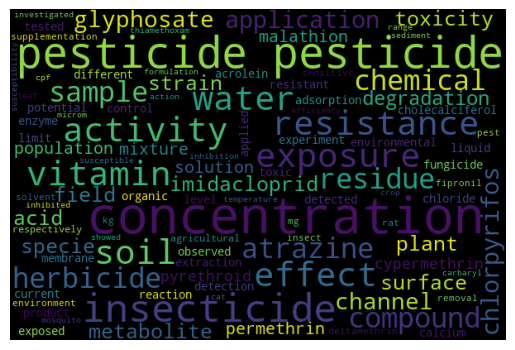

In [79]:

utils.make_wordcloud(wc_string)

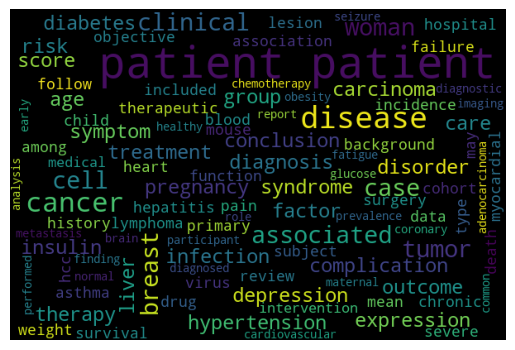

In [73]:
wc_string = make_string(subtracted_contr.copy())
utils.make_wordcloud(wc_string)

## Now with the more recent reference set: 
(`'./data/validation_set_master.csv'`)

In [5]:
#run this to reload the entrez_utils module after changes during session
from importlib import reload 
reload(utils);

data = utils.read_abstract_data(file1, file3)
data.head()
# no need to catch return value; dataframe operations are in-place
# no need to remove punctuation in this step when using nltk.tokenize_word() 
# which is implemented in utils.tokenize_text()
#utils.preprocess_text(data)
#data.head()

(4944, 3)
(878, 3)


,pmid,title,abstract,label,text_label
0,29990300,Oxidative stress in triazine pesticide toxicit...,This review article provides a summary of the ...,1,pest
1,29990732,Toxicity induced by glyphosate and glyphosate-...,Glyphosate is the active component of many com...,1,pest
2,29999060,Direct kinetics study of CH2OO + methyl vinyl ...,Methyl vinyl ketone (MVK) and methacrolein (MA...,1,pest
3,30003825,Dihydromyricetin improves vascular hyporespons...,CONTEXT: Dihydromyricetin (DMY) has oxidation ...,1,pest
4,30015122,Glyphosate and atrazine in rainfall and soils ...,The presence in the atmosphere of glyphosate (...,1,pest


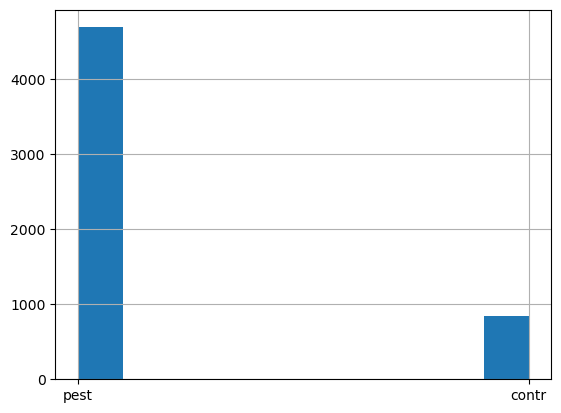

In [101]:
data[label_selection].hist();